In [67]:

import numpy as np
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils
import pandas as pd
import pickle
import albumentations as A
from glob import glob
import os
from tqdm import tqdm
import cv2
from mmcv import Config
from mmseg.datasets import build_dataloader, build_dataset

In [161]:
def dense_crf(img, output_probs):
    MAX_ITER = 10
    POS_W = 3
    POS_XY_STD = 3
    Bi_W = 4
    Bi_XY_STD = 49
    Bi_RGB_STD = 5

    c,h,w = output_probs.shape

    U = utils.unary_from_softmax(output_probs.squeeze())

    U = np.ascontiguousarray(U)

    img = np.ascontiguousarray(img.squeeze()).astype(np.uint8)

    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)

    # d.addPairwiseGaussian(sxy=3, compat=3)
    # d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=img, compat=10)
    d.addPairwiseGaussian(sxy=POS_XY_STD, compat=POS_W)
    d.addPairwiseBilateral(sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=img, compat=Bi_W)

    Q = d.inference(MAX_ITER)
    Q = np.array(Q).reshape((c, h, w))
    return Q


In [14]:
MODEL = 'OCR_dyunetCBAM_swinB.py' # model config 경로
PATH = '/opt/ml/segmentation/moon/mmsegmentation/work_dirs/OCR_dyunetCBAM_swinB_cv2' # 모델 저장된 폴더
OUTPUT_PATH = glob(os.path.join(PATH,'output*'))

assert len(OUTPUT_PATH)==1
output_path = OUTPUT_PATH[0]
with open(output_path,'rb') as f:
    output = pickle.load(f)

In [24]:
ROOT = '/opt/ml/segmentation/input/data/'
IMG_PATH = '/opt/ml/segmentation/moon/dataset/images/test/'

In [70]:
cfg =Config.fromfile(os.path.join(PATH,MODEL))
cfg.data.test.test_mode = True
cfg.data.test.img_dir = 'images/test'
cfg.data.test.ann_dir = None
test_dataset = build_dataset(cfg.data.test)
test_loader = build_dataloader(
        test_dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

2021-10-30 13:24:15,574 - mmseg - INFO - Loaded 819 images


In [78]:
file_name = [ '/'.join(path['filename'].split('+')) for path in test_dataset.img_infos]
imgs_path =  [ os.path.join(ROOT,path) for path in file_name]

In [153]:
imgs = []
for img_path in tqdm(imgs_path):
    img = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
    imgs.append(img)

100%|██████████| 819/819 [00:03<00:00, 212.01it/s]


In [162]:
crf_outputs = []
for idx,(out,img) in enumerate(tqdm(zip(output,imgs))):
    crf_output = dense_crf(img,out)
    crf_outputs.append(crf_output)

819it [16:12,  1.19s/it]


In [163]:
for idx in tqdm(range(len(crf_outputs))):
    crf_outputs[idx] = crf_outputs[idx].squeeze().argmax(axis=0)

100%|██████████| 819/819 [00:02<00:00, 293.43it/s]


## visualization

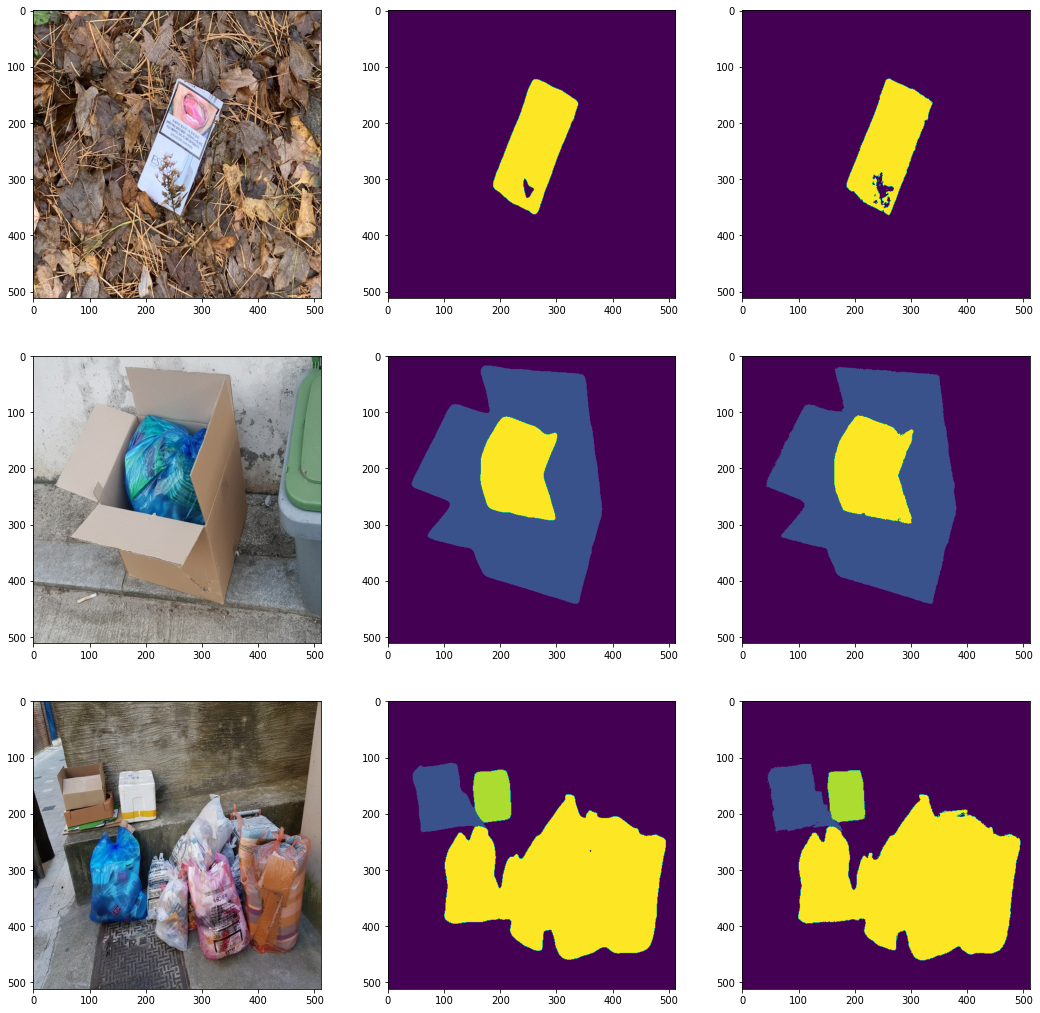

In [167]:
import matplotlib.pyplot as plt
idx = 0

fig,axes = plt.subplots(3,3,figsize=(18,18))
for idx in range(3):
    i = np.random.randint(0,len(imgs))
    axes[idx][0].imshow(imgs[i])
    axes[idx][1].imshow(output[i].argmax(axis=0))
    axes[idx][2].imshow(crf_outputs[i])
plt.show()

In [168]:
size = 256
transform = A.Compose([A.Resize(size, size)])

file_name_list=[]
preds_array = np.empty((0,size*size),dtype=np.int64)

for idx,out in tqdm(enumerate(crf_outputs)):
    image = np.zeros((1,size,size))
    transformed = transform(image=image,mask=out)
    mask = transformed['mask']
    
    mask = mask.reshape(-1,size*size).astype(int)
    preds_array = np.vstack((preds_array,mask))
    
    file_name_list.append(file_name[idx])
    

819it [03:19,  4.11it/s]


In [169]:
# sample_submisson.csv 열기
tmp_submission = pd.read_csv('/opt/ml/segmentation/baseline_code/submission/sample_submission.csv', index_col=None)

# PredictionString 대입
for file_name, string in zip(file_name_list, preds_array):
    #file_name = '/'.join(file_name.split('+'))
    tmp_submission = tmp_submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장

# 순서도 같아야 채점이 되기 때문에 sample_submission이 필요
sample = pd.read_csv('/opt/ml/segmentation/moon/submission/sample_submission.csv', index_col=None)
submission = pd.read_csv('/opt/ml/segmentation/baseline_code/submission/sample_submission.csv', index_col=None)
for image_id in sample['image_id'].tolist():
    prediction_string = tmp_submission[tmp_submission['image_id']==image_id]['PredictionString'].iloc[0]
    submission = submission.append({"image_id" : image_id, "PredictionString" : prediction_string }, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv(f"./submission/{MODEL.split('.')[0]}_cv2_CRF_TTA.csv", index=False)